# Lymphoma classification - Augmented, Untransformed Dataset

### Importing the required libraries

In [2]:
import pathlib
import tensorflow as tf
import matplotlib.pyplot as plt
from skimage import io
from skimage import exposure
import cv2
import numpy as np
import pandas as pd
import glob
import os
import PIL
from tensorflow import keras
from tensorflow.keras.utils import to_categorical
from tensorflow.keras import layers
from keras.layers import Input, Dense, Flatten, Dropout, LeakyReLU, Activation
from keras.models import Model
from keras.applications.densenet import DenseNet121
from keras.applications.resnet import ResNet50
from keras.applications.inception_v3 import InceptionV3
from tensorflow.keras.models import Sequential
import splitfolders
from sklearn.utils import shuffle
from sklearn.metrics import confusion_matrix
import seaborn as sns

In [ ]:
!pip install split-folders

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


### Dataset visualisation

In [3]:
DATASET_PATH = 'D:\Research\Lymphoma_Classification\Lymphoma'

# There are three classes of images that we will deal with
cls = ['CLL', 'FL', 'MCL']

Text(0.5, 1.0, 'MCL')

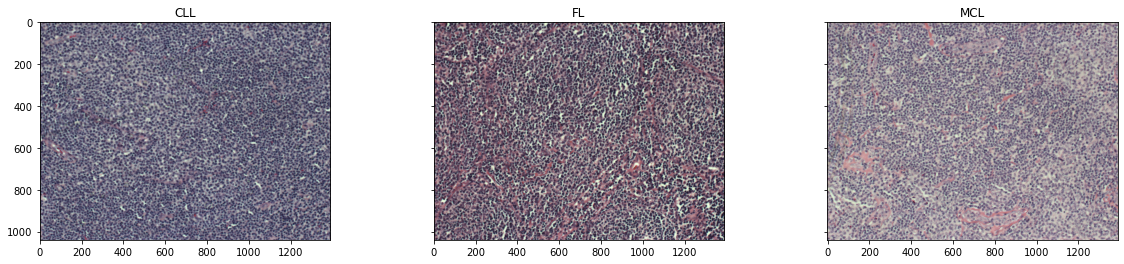

In [4]:
cll_path = os.path.join(DATASET_PATH, cls[0], '*')
cll = glob.glob(cll_path)
cll_img = io.imread(cll[0])

fl_path = os.path.join(DATASET_PATH, cls[1], '*')
fl = glob.glob(fl_path)
fl_img = io.imread(fl[0])

mcl_path = os.path.join(DATASET_PATH, cls[2], '*')
mcl = glob.glob(mcl_path)
mcl_img = io.imread(mcl[0])

f, axes = plt.subplots(1, 3, sharey=True)
f.set_figwidth(20)
        
axes[0].imshow(cll_img)
axes[1].imshow(fl_img)
axes[2].imshow(mcl_img)

axes[0].set_title('CLL')
axes[1].set_title('FL')
axes[2].set_title('MCL')

In [5]:
len(cll)

113

In [6]:
len(fl)

139

In [7]:
len(mcl)

122

In [8]:
cll_img.shape

(1040, 1388, 3)

In [9]:
fl_img.shape

(1040, 1388, 3)

In [10]:
mcl_img.shape

(1040, 1388, 3)

### Augmentation

In [ ]:
cll_path = 'D:\Research\Lymphoma_Classification\Lymphoma\CLL'
fl_path = 'D:\Research\Lymphoma_Classification\Lymphoma\FL'
mcl_path = 'D:\Research\Lymphoma_Classification\Lymphoma\MCL'

In [ ]:
# Augmenting the class CLL
aug = Augmentor.Pipeline(cll_path)
aug.resize(probability=1, width=224, height=224)
aug.rotate(probability=0.4, max_left_rotation=3, max_right_rotation=3)
aug.random_distortion(probability=0.4, grid_width=4, grid_height=4, magnitude=4)
aug.sample(280)

Initialised with 113 image(s) found.
Output directory set to D:\Research\Lymphoma_Classification\Lymphoma\CLL\output.

Processing <PIL.Image.Image image mode=RGB size=224x224 at 0x1D8A8800DC0>: 100%|██████████| 280/280 [00:06<00:00, 45.68 Samples/s]


In [ ]:
# Augmenting the class FL
aug = Augmentor.Pipeline(fl_path)
aug.resize(probability=1, width=224, height=224)
aug.rotate(probability=0.4, max_left_rotation=3, max_right_rotation=3)
aug.random_distortion(probability=0.4, grid_width=4, grid_height=4, magnitude=4)
aug.sample(280)

Initialised with 139 image(s) found.
Output directory set to D:\Research\Lymphoma_Classification\Lymphoma\FL\output.

Processing <PIL.Image.Image image mode=RGB size=224x224 at 0x1D8ADF84070>: 100%|██████████| 280/280 [00:11<00:00, 25.35 Samples/s]


In [ ]:
# Augmenting the class MCL
aug = Augmentor.Pipeline(mcl_path)
aug.resize(probability=1, width=224, height=224)
aug.rotate(probability=0.4, max_left_rotation=3, max_right_rotation=3)
aug.random_distortion(probability=0.4, grid_width=4, grid_height=4, magnitude=4)
aug.sample(280)

Initialised with 122 image(s) found.
Output directory set to D:\Research\Lymphoma_Classification\Lymphoma\MCL\output.

Processing <PIL.Image.Image image mode=RGB size=224x224 at 0x1D8A9374F40>: 100%|██████████| 280/280 [00:07<00:00, 35.31 Samples/s]


### Splitting the dataset into train and test sets

In [ ]:
DATASET_PATH = "D:\\Research\\Lymphoma_Classification\\Augmented"

In [ ]:
splitfolders.ratio(DATASET_PATH, output="s_augmented", seed=1337, ratio=(.8, 0.1, 0.1)) 

Copying files: 840 files [00:03, 226.00 files/s]


### Function for Converting TIF images to numpy arrays

In [ ]:
def numpy_data(dataset_dir):
    data_array = []
    data_labels = []
    class_counter = 0

    classes_names = os.listdir(dataset_dir)
    for current_class_name in classes_names:
        class_dir = os.path.join(dataset_dir, current_class_name)
        images_in_class = os.listdir(class_dir)

        print("Class index", class_counter, ", ", current_class_name, ":" , len(images_in_class))

        for image_file in images_in_class:
            if image_file.endswith(".tif"):
                image_file_dir = os.path.join(class_dir, image_file)

                img = keras.preprocessing.image.load_img(image_file_dir, target_size=(224, 224))
                img_array = keras.preprocessing.image.img_to_array(img)

                img_array = img_array/255.0

                data_array.append(img_array)
                data_labels.append(class_counter)
        class_counter = class_counter + 1
    data_array = np.array(data_array)
    data_labels = np.array(data_labels)
    print(" Data Array Shape :", data_array.shape)
    return data_array, data_labels

In [ ]:
dataset_dir = "/content/drive/MyDrive/s_augmented/train"
X_train, y_train = numpy_data(dataset_dir)

Class index 0 ,  FL : 224
Class index 1 ,  CLL : 224
Class index 2 ,  MCL : 224
Training Data Array Shape : (672, 224, 224, 3)


In [ ]:
X_train, y_train = shuffle(X_train, y_train)

In [ ]:
y_train = to_categorical(y_train)

In [ ]:
y_train.shape

(672, 3)

### Converting TIF val images to numpy array

In [ ]:
dataset_dir = "/content/drive/MyDrive/s_augmented/val"
X_val, y_val = numpy_data(dataset_dir)

Class index 0 ,  CLL : 28
Class index 1 ,  FL : 28
Class index 2 ,  MCL : 28
Test Data Array Shape : (84, 224, 224, 3)


In [ ]:
X_val, y_val = shuffle(X_val, y_val)

In [ ]:
y_val = to_categorical(y_val)

### Converting TIF test images to numpy array

In [ ]:
dataset_dir = "/content/drive/MyDrive/s_augmented/test"
X_test, y_test = numpy_data(dataset_dir

Class index 0 ,  FL : 28
Class index 1 ,  CLL : 28
Class index 2 ,  MCL : 28
Test Data Array Shape : (84, 224, 224, 3)


In [ ]:
X_test, y_test = shuffle(X_test, y_test)

In [ ]:
y_test = to_categorical(y_test)

### Model building

In [ ]:
img_dim = X_train.shape[1:]
batch_size = 32

### DenseNet121

#### 512 nodes on custom layer 

In [ ]:
# load model
model1 = DenseNet121(weights='imagenet', include_top=False, input_shape= img_dim)
# add new classifier layers
flat1 = Flatten()(model1.layers[-1].output)
class1 = Dense(512, activation='relu')(flat1)
output = Dense(3, activation='softmax')(class1)
# define new model
model1 = Model(inputs=model1.inputs, outputs=output)
# summarize
model1.summary()

29097984/29084464 [==============================] - 0s 0us/step
Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 zero_padding2d (ZeroPadding2D)  (None, 230, 230, 3)  0          ['input_1[0][0]']                
                                                                                                  
 conv1/conv (Conv2D)            (None, 112, 112, 64  9408        ['zero_padding2d[0][0]']         
                                )                                                                 
                             

In [ ]:
model1.compile(optimizer = tf.keras.optimizers.Adam(learning_rate=0.0001), loss = 'categorical_crossentropy',metrics = ['Accuracy', 'Precision', 'Recall'])

In [ ]:
densehist1 = model1.fit(X_train, y_train, validation_data=(X_val, y_val), batch_size = batch_size, epochs = 40)

Epoch 1/40
21/21 [==============================] - 29s 321ms/step - loss: 2.8393 - Accuracy: 0.5089 - precision: 0.5256 - recall: 0.4881 - val_loss: 1.4863 - val_Accuracy: 0.3214 - val_precision: 0.3200 - val_recall: 0.2857
Epoch 2/40
21/21 [==============================] - 4s 210ms/step - loss: 0.2124 - Accuracy: 0.9435 - precision: 0.9527 - recall: 0.9301 - val_loss: 3.3355 - val_Accuracy: 0.3095 - val_precision: 0.3095 - val_recall: 0.3095
Epoch 3/40
21/21 [==============================] - 5s 216ms/step - loss: 0.0697 - Accuracy: 0.9807 - precision: 0.9836 - recall: 0.9807 - val_loss: 3.2764 - val_Accuracy: 0.2857 - val_precision: 0.2892 - val_recall: 0.2857
Epoch 4/40
21/21 [==============================] - 4s 210ms/step - loss: 0.0144 - Accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - val_loss: 4.8800 - val_Accuracy: 0.2976 - val_precision: 0.2976 - val_recall: 0.2976
Epoch 5/40
21/21 [==============================] - 5s 216ms/step - loss: 0.0045 - Accuracy: 1.0000 - p

In [ ]:
predictions = model1.predict(X_test)
predictions = np.argmax(predictions, axis=1)

rounded_labels=np.argmax(y_test, axis=1)
rounded_labels[1]
from sklearn.metrics import classification_report
print(classification_report(rounded_labels,predictions,target_names = ['CLL','FL','MCL']))

              precision    recall  f1-score   support

         CLL       0.97      1.00      0.98        28
          FL       0.97      1.00      0.98        28
         MCL       1.00      0.93      0.96        28

    accuracy                           0.98        84
   macro avg       0.98      0.98      0.98        84
weighted avg       0.98      0.98      0.98        84



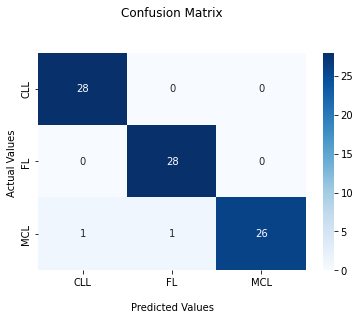

In [ ]:
target_names = ['CLL','FL','MCL']
cf_matrix = confusion_matrix(rounded_labels, predictions)
ax = sns.heatmap(cf_matrix, annot=True, cmap='Blues')
ax.set_title('Confusion Matrix\n\n');
ax.set_xlabel('\nPredicted Values')
ax.set_ylabel('Actual Values ');
## Ticket labels - List must be in alphabetical order
ax.xaxis.set_ticklabels(target_names)
ax.yaxis.set_ticklabels(target_names)
## Display the visualization of the Confusion Matrix.
plt.show()

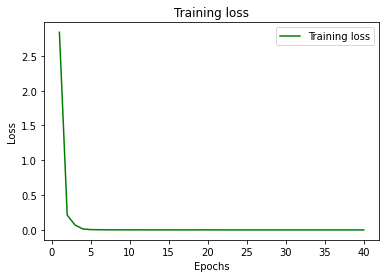

In [ ]:
loss_train = densehist1.history['loss']
epochs = range(1,41)
plt.plot(epochs, loss_train, 'g', label='Training loss')
plt.title('Training loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

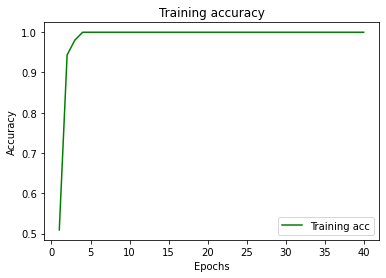

In [ ]:
acc_train = densehist1.history['Accuracy']
epochs = range(1,41)
plt.plot(epochs, acc_train, 'g', label='Training acc')
plt.title('Training accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

#### 1024 nodes on custom layer

In [ ]:
# load model
model2 = DenseNet121(weights='imagenet', include_top=False, input_shape= img_dim)
# add new classifier layers
flat1 = Flatten()(model2.layers[-1].output)
class1 = Dense(1024, activation='relu')(flat1)
output = Dense(3, activation='softmax')(class1)
# define new model
model2 = Model(inputs=model2.inputs, outputs=output)
# summarize
model2.summary()

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_2 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 zero_padding2d_2 (ZeroPadding2  (None, 230, 230, 3)  0          ['input_2[0][0]']                
 D)                                                                                               
                                                                                                  
 conv1/conv (Conv2D)            (None, 112, 112, 64  9408        ['zero_padding2d_2[0][0]']       
                                )                                                           

In [ ]:
model2.compile(optimizer = tf.keras.optimizers.Adam(learning_rate=0.0001), loss = 'categorical_crossentropy',metrics = ['Accuracy', 'Precision', 'Recall'])

In [ ]:
densehist2 = model2.fit(X_train, y_train, validation_data=(X_val, y_val), batch_size = batch_size, epochs = 40)

Epoch 1/40
21/21 [==============================] - 18s 319ms/step - loss: 3.5047 - Accuracy: 0.5446 - precision: 0.5559 - recall: 0.5402 - val_loss: 1.6850 - val_Accuracy: 0.2619 - val_precision: 0.2857 - val_recall: 0.2619
Epoch 2/40
21/21 [==============================] - 5s 218ms/step - loss: 0.2061 - Accuracy: 0.9360 - precision: 0.9454 - recall: 0.9271 - val_loss: 2.8450 - val_Accuracy: 0.3095 - val_precision: 0.3171 - val_recall: 0.3095
Epoch 3/40
21/21 [==============================] - 5s 219ms/step - loss: 0.0477 - Accuracy: 0.9896 - precision: 0.9896 - recall: 0.9866 - val_loss: 4.3514 - val_Accuracy: 0.3333 - val_precision: 0.3333 - val_recall: 0.3333
Epoch 4/40
21/21 [==============================] - 4s 212ms/step - loss: 0.0107 - Accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - val_loss: 5.1880 - val_Accuracy: 0.3214 - val_precision: 0.3133 - val_recall: 0.3095
Epoch 5/40
21/21 [==============================] - 5s 220ms/step - loss: 0.0042 - Accuracy: 1.0000 - p

In [ ]:
predictions = model2.predict(X_test)
predictions = np.argmax(predictions, axis=1)

rounded_labels=np.argmax(y_test, axis=1)
rounded_labels[1]
from sklearn.metrics import classification_report
print(classification_report(rounded_labels,predictions,target_names = ['CLL','FL','MCL']))

              precision    recall  f1-score   support

         CLL       0.96      0.96      0.96        28
          FL       0.97      1.00      0.98        28
         MCL       0.96      0.93      0.95        28

    accuracy                           0.96        84
   macro avg       0.96      0.96      0.96        84
weighted avg       0.96      0.96      0.96        84



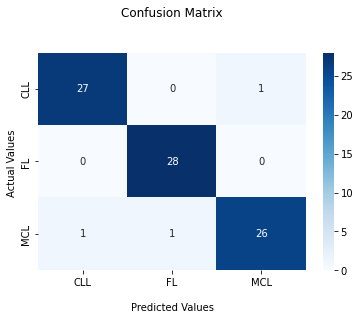

In [ ]:
target_names = ['CLL','FL','MCL']
cf_matrix = confusion_matrix(rounded_labels, predictions)
ax = sns.heatmap(cf_matrix, annot=True, cmap='Blues')
ax.set_title('Confusion Matrix\n\n');
ax.set_xlabel('\nPredicted Values')
ax.set_ylabel('Actual Values ');
## Ticket labels - List must be in alphabetical order
ax.xaxis.set_ticklabels(target_names)
ax.yaxis.set_ticklabels(target_names)
## Display the visualization of the Confusion Matrix.
plt.show()

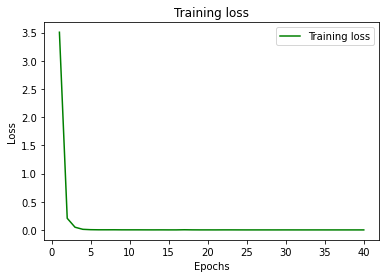

In [ ]:
loss_train = densehist2.history['loss']
epochs = range(1,41)
plt.plot(epochs, loss_train, 'g', label='Training loss')
plt.title('Training loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

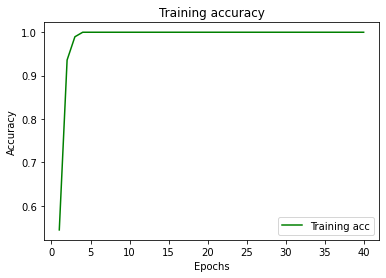

In [ ]:
acc_train = densehist2.history['Accuracy']
epochs = range(1,41)
plt.plot(epochs, acc_train, 'g', label='Training acc')
plt.title('Training accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

#### 512 nodes on custom layer

In [ ]:
# load model
model3 = DenseNet121(weights='imagenet', include_top=False, input_shape= img_dim)
# add new classifier layers
flat1 = Flatten()(model3.layers[-1].output)
class1 = Dense(512, activation='relu')(flat1)
output = Dense(3, activation='softmax')(class1)
# define new model
model3 = Model(inputs=model3.inputs, outputs=output)
# summarize
model3.summary()

Model: "model_2"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_3 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 zero_padding2d_4 (ZeroPadding2  (None, 230, 230, 3)  0          ['input_3[0][0]']                
 D)                                                                                               
                                                                                                  
 conv1/conv (Conv2D)            (None, 112, 112, 64  9408        ['zero_padding2d_4[0][0]']       
                                )                                                           

In [ ]:
model3.compile(optimizer = tf.keras.optimizers.Adam(learning_rate=0.0001), loss = 'categorical_crossentropy',metrics = ['Accuracy', 'Precision', 'Recall'])

In [ ]:
densehist3 = model3.fit(X_train, y_train, validation_data=(X_val, y_val), batch_size = batch_size, epochs = 80)

Epoch 1/80
21/21 [==============================] - 17s 305ms/step - loss: 2.6295 - Accuracy: 0.5238 - precision: 0.5375 - recall: 0.5015 - val_loss: 1.5786 - val_Accuracy: 0.3333 - val_precision: 0.3377 - val_recall: 0.3095
Epoch 2/80
21/21 [==============================] - 4s 209ms/step - loss: 0.1614 - Accuracy: 0.9554 - precision: 0.9651 - recall: 0.9464 - val_loss: 2.3495 - val_Accuracy: 0.3333 - val_precision: 0.3253 - val_recall: 0.3214
Epoch 3/80
21/21 [==============================] - 4s 209ms/step - loss: 0.0361 - Accuracy: 0.9970 - precision: 0.9970 - recall: 0.9940 - val_loss: 4.0294 - val_Accuracy: 0.3333 - val_precision: 0.3333 - val_recall: 0.3333
Epoch 4/80
21/21 [==============================] - 4s 208ms/step - loss: 0.0089 - Accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - val_loss: 5.3221 - val_Accuracy: 0.3333 - val_precision: 0.3333 - val_recall: 0.3333
Epoch 5/80
21/21 [==============================] - 4s 208ms/step - loss: 0.0054 - Accuracy: 0.9985 - p

In [ ]:
predictions = model3.predict(X_test)
predictions = np.argmax(predictions, axis=1)

rounded_labels=np.argmax(y_test, axis=1)
rounded_labels[1]
from sklearn.metrics import classification_report
print(classification_report(rounded_labels,predictions,target_names = ['CLL','FL','MCL']))

              precision    recall  f1-score   support

         CLL       0.93      1.00      0.97        28
          FL       0.90      0.96      0.93        28
         MCL       1.00      0.86      0.92        28

    accuracy                           0.94        84
   macro avg       0.94      0.94      0.94        84
weighted avg       0.94      0.94      0.94        84



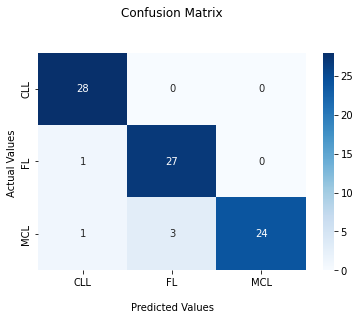

In [ ]:
target_names = ['CLL','FL','MCL']
cf_matrix = confusion_matrix(rounded_labels, predictions)
ax = sns.heatmap(cf_matrix, annot=True, cmap='Blues')
ax.set_title('Confusion Matrix\n\n');
ax.set_xlabel('\nPredicted Values')
ax.set_ylabel('Actual Values ');
## Ticket labels - List must be in alphabetical order
ax.xaxis.set_ticklabels(target_names)
ax.yaxis.set_ticklabels(target_names)
## Display the visualization of the Confusion Matrix.
plt.show()

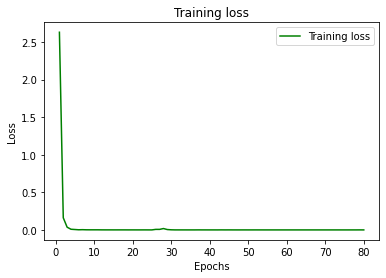

In [ ]:
loss_train = densehist3.history['loss']
epochs = range(1,81)
plt.plot(epochs, loss_train, 'g', label='Training loss')
plt.title('Training loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

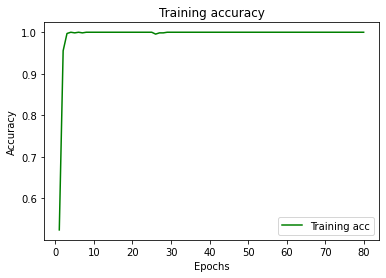

In [ ]:
acc_train = densehist3.history['Accuracy']
epochs = range(1,81)
plt.plot(epochs, acc_train, 'g', label='Training acc')
plt.title('Training accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

#### 1024 nodes on custom layer

In [ ]:
# load model
model4 = DenseNet121(weights='imagenet', include_top=False, input_shape= img_dim)
# add new classifier layers
flat1 = Flatten()(model4.layers[-1].output)
class1 = Dense(1024, activation='relu')(flat1)
output = Dense(3, activation='softmax')(class1)
# define new model
model4 = Model(inputs=model4.inputs, outputs=output)
# summarize
model4.summary()

Model: "model_3"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_4 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 zero_padding2d_6 (ZeroPadding2  (None, 230, 230, 3)  0          ['input_4[0][0]']                
 D)                                                                                               
                                                                                                  
 conv1/conv (Conv2D)            (None, 112, 112, 64  9408        ['zero_padding2d_6[0][0]']       
                                )                                                           

In [ ]:
model4.compile(optimizer = tf.keras.optimizers.Adam(learning_rate=0.0001), loss = 'categorical_crossentropy',metrics = ['Accuracy', 'Precision', 'Recall'])

In [ ]:
densehist4 = model4.fit(X_train, y_train, validation_data=(X_val, y_val), batch_size = batch_size, epochs = 80)

Epoch 1/80
21/21 [==============================] - 18s 308ms/step - loss: 2.8779 - Accuracy: 0.5551 - precision: 0.5591 - recall: 0.5417 - val_loss: 3.5133 - val_Accuracy: 0.3333 - val_precision: 0.3253 - val_recall: 0.3214
Epoch 2/80
21/21 [==============================] - 4s 211ms/step - loss: 0.1614 - Accuracy: 0.9479 - precision: 0.9548 - recall: 0.9420 - val_loss: 3.5687 - val_Accuracy: 0.3214 - val_precision: 0.3214 - val_recall: 0.3214
Epoch 3/80
21/21 [==============================] - 4s 212ms/step - loss: 0.0268 - Accuracy: 0.9955 - precision: 0.9970 - recall: 0.9955 - val_loss: 5.7229 - val_Accuracy: 0.3333 - val_precision: 0.3333 - val_recall: 0.3333
Epoch 4/80
21/21 [==============================] - 4s 212ms/step - loss: 0.0136 - Accuracy: 0.9970 - precision: 0.9970 - recall: 0.9970 - val_loss: 7.3486 - val_Accuracy: 0.3214 - val_precision: 0.3214 - val_recall: 0.3214
Epoch 5/80
21/21 [==============================] - 4s 211ms/step - loss: 0.0041 - Accuracy: 1.0000 - p

In [ ]:
predictions = model4.predict(X_test)
predictions = np.argmax(predictions, axis=1)

rounded_labels=np.argmax(y_test, axis=1)
rounded_labels[1]
from sklearn.metrics import classification_report
print(classification_report(rounded_labels,predictions,target_names = ['CLL','FL','MCL']))

              precision    recall  f1-score   support

         CLL       0.97      1.00      0.98        28
          FL       0.96      0.96      0.96        28
         MCL       0.96      0.93      0.95        28

    accuracy                           0.96        84
   macro avg       0.96      0.96      0.96        84
weighted avg       0.96      0.96      0.96        84



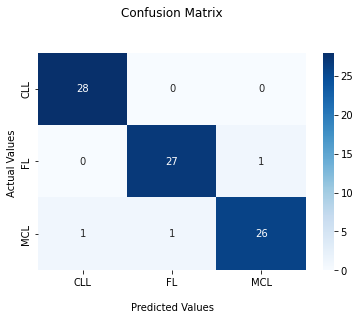

In [ ]:
target_names = ['CLL','FL','MCL']
cf_matrix = confusion_matrix(rounded_labels, predictions)
ax = sns.heatmap(cf_matrix, annot=True, cmap='Blues')
ax.set_title('Confusion Matrix\n\n');
ax.set_xlabel('\nPredicted Values')
ax.set_ylabel('Actual Values ');
## Ticket labels - List must be in alphabetical order
ax.xaxis.set_ticklabels(target_names)
ax.yaxis.set_ticklabels(target_names)
## Display the visualization of the Confusion Matrix.
plt.show()

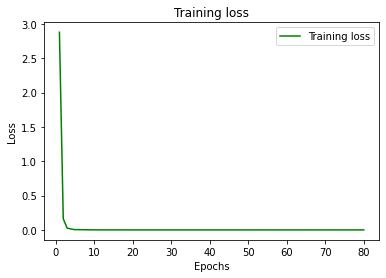

In [ ]:
loss_train = densehist4.history['loss']
epochs = range(1,81)
plt.plot(epochs, loss_train, 'g', label='Training loss')
plt.title('Training loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

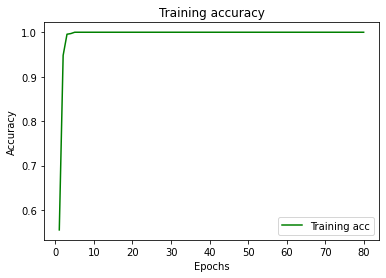

In [ ]:
acc_train = densehist4.history['Accuracy']
epochs = range(1,81)
plt.plot(epochs, acc_train, 'g', label='Training acc')
plt.title('Training accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

### DenseNet201

#### 512 nodes on custom layer

In [ ]:
# load model
from keras.applications.densenet import DenseNet201
model5 = DenseNet201(weights='imagenet', include_top=False, input_shape= img_dim)
# add new classifier layers
flat1 = Flatten()(model5.layers[-1].output)
class1 = Dense(512, activation='relu')(flat1)
output = Dense(3, activation='softmax')(class1)
# define new model
model5 = Model(inputs=model5.inputs, outputs=output)
# summarize
model5.summary()

74850304/74836368 [==============================] - 3s 0us/step
Model: "model_4"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_5 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 zero_padding2d_8 (ZeroPadding2  (None, 230, 230, 3)  0          ['input_5[0][0]']                
 D)                                                                                               
                                                                                                  
 conv1/conv (Conv2D)            (None, 112, 112, 64  9408        ['zero_padding2d_8[0][0]']       
                           

In [ ]:
model5.compile(optimizer = tf.keras.optimizers.Adam(learning_rate=0.0001), loss = 'categorical_crossentropy',metrics = ['Accuracy', 'Precision', 'Recall'])

In [ ]:
densehist5 = model5.fit(X_train, y_train, validation_data=(X_val, y_val), batch_size = batch_size, epochs = 40)

Epoch 1/40
21/21 [==============================] - 32s 486ms/step - loss: 2.5288 - Accuracy: 0.5208 - precision: 0.5301 - recall: 0.4851 - val_loss: 1.2674 - val_Accuracy: 0.3452 - val_precision: 0.2881 - val_recall: 0.2024
Epoch 2/40
21/21 [==============================] - 7s 323ms/step - loss: 0.2023 - Accuracy: 0.9375 - precision: 0.9433 - recall: 0.9167 - val_loss: 2.0292 - val_Accuracy: 0.3571 - val_precision: 0.3415 - val_recall: 0.3333
Epoch 3/40
21/21 [==============================] - 7s 324ms/step - loss: 0.0285 - Accuracy: 0.9985 - precision: 0.9985 - recall: 0.9955 - val_loss: 2.3587 - val_Accuracy: 0.3333 - val_precision: 0.3373 - val_recall: 0.3333
Epoch 4/40
21/21 [==============================] - 7s 324ms/step - loss: 0.0063 - Accuracy: 0.9985 - precision: 0.9985 - recall: 0.9985 - val_loss: 3.4171 - val_Accuracy: 0.3333 - val_precision: 0.3333 - val_recall: 0.3333
Epoch 5/40
21/21 [==============================] - 7s 323ms/step - loss: 0.0026 - Accuracy: 1.0000 - p

In [ ]:
predictions = model5.predict(X_test)
predictions = np.argmax(predictions, axis=1)

rounded_labels=np.argmax(y_test, axis=1)
rounded_labels[1]
from sklearn.metrics import classification_report
print(classification_report(rounded_labels,predictions,target_names = ['CLL','FL','MCL']))

              precision    recall  f1-score   support

         CLL       0.97      1.00      0.98        28
          FL       0.93      0.96      0.95        28
         MCL       0.96      0.89      0.93        28

    accuracy                           0.95        84
   macro avg       0.95      0.95      0.95        84
weighted avg       0.95      0.95      0.95        84



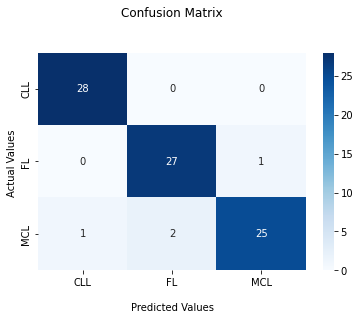

In [ ]:
target_names = ['CLL','FL','MCL']
cf_matrix = confusion_matrix(rounded_labels, predictions)
ax = sns.heatmap(cf_matrix, annot=True, cmap='Blues')
ax.set_title('Confusion Matrix\n\n');
ax.set_xlabel('\nPredicted Values')
ax.set_ylabel('Actual Values ');
## Ticket labels - List must be in alphabetical order
ax.xaxis.set_ticklabels(target_names)
ax.yaxis.set_ticklabels(target_names)
## Display the visualization of the Confusion Matrix.
plt.show()

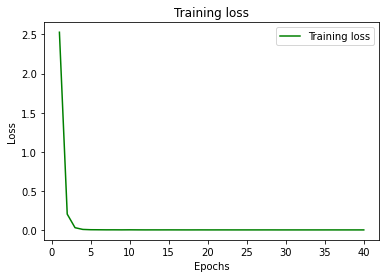

In [ ]:
loss_train = densehist5.history['loss']
epochs = range(1,41)
plt.plot(epochs, loss_train, 'g', label='Training loss')
plt.title('Training loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

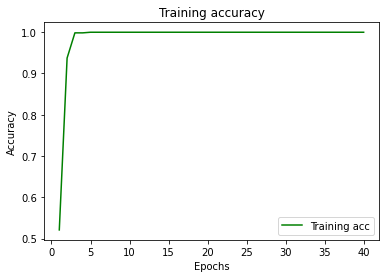

In [ ]:
acc_train = densehist5.history['Accuracy']
epochs = range(1,41)
plt.plot(epochs, acc_train, 'g', label='Training acc')
plt.title('Training accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

#### 1024 nodes on custom layer

In [ ]:
# load model
from keras.applications.densenet import DenseNet201
model6 = DenseNet201(weights='imagenet', include_top=False, input_shape= img_dim)
# add new classifier layers
flat1 = Flatten()(model6.layers[-1].output)
class1 = Dense(1024, activation='relu')(flat1)
output = Dense(3, activation='softmax')(class1)
# define new model
model6 = Model(inputs=model6.inputs, outputs=output)
# summarize
model6.summary()

Model: "model_6"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_7 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 zero_padding2d_12 (ZeroPadding  (None, 230, 230, 3)  0          ['input_7[0][0]']                
 2D)                                                                                              
                                                                                                  
 conv1/conv (Conv2D)            (None, 112, 112, 64  9408        ['zero_padding2d_12[0][0]']      
                                )                                                           

In [ ]:
model6.compile(optimizer = tf.keras.optimizers.Adam(learning_rate=0.0001), loss = 'categorical_crossentropy',metrics = ['Accuracy', 'Precision', 'Recall'])

In [ ]:
densehist6 = model6.fit(X_train, y_train, validation_data=(X_val, y_val), batch_size = batch_size, epochs = 40)

Epoch 1/40
21/21 [==============================] - 29s 605ms/step - loss: 2.1024 - Accuracy: 0.6235 - precision: 0.6308 - recall: 0.6101 - val_loss: 1.8243 - val_Accuracy: 0.3571 - val_precision: 0.3247 - val_recall: 0.2976
Epoch 2/40
21/21 [==============================] - 7s 329ms/step - loss: 0.1157 - Accuracy: 0.9598 - precision: 0.9626 - recall: 0.9568 - val_loss: 2.1963 - val_Accuracy: 0.4167 - val_precision: 0.4103 - val_recall: 0.3810
Epoch 3/40
21/21 [==============================] - 7s 336ms/step - loss: 0.0115 - Accuracy: 0.9970 - precision: 0.9970 - recall: 0.9970 - val_loss: 4.1946 - val_Accuracy: 0.3571 - val_precision: 0.3571 - val_recall: 0.3571
Epoch 4/40
21/21 [==============================] - 7s 330ms/step - loss: 0.0040 - Accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - val_loss: 4.2591 - val_Accuracy: 0.3452 - val_precision: 0.3452 - val_recall: 0.3452
Epoch 5/40
21/21 [==============================] - 7s 329ms/step - loss: 0.0014 - Accuracy: 1.0000 - p

In [ ]:
predictions = model6.predict(X_test)
predictions = np.argmax(predictions, axis=1)

rounded_labels=np.argmax(y_test, axis=1)
rounded_labels[1]
from sklearn.metrics import classification_report
print(classification_report(rounded_labels,predictions,target_names = ['CLL','FL','MCL']))

              precision    recall  f1-score   support

         CLL       0.96      0.96      0.96        28
          FL       1.00      0.96      0.98        28
         MCL       0.93      0.96      0.95        28

    accuracy                           0.96        84
   macro avg       0.97      0.96      0.96        84
weighted avg       0.97      0.96      0.96        84



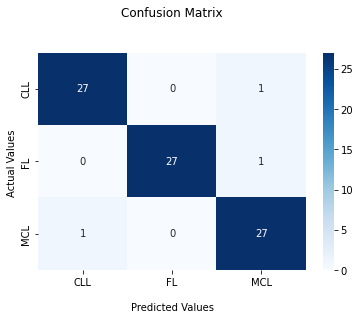

In [ ]:
target_names = ['CLL','FL','MCL']
cf_matrix = confusion_matrix(rounded_labels, predictions)
ax = sns.heatmap(cf_matrix, annot=True, cmap='Blues')
ax.set_title('Confusion Matrix\n\n');
ax.set_xlabel('\nPredicted Values')
ax.set_ylabel('Actual Values ');
## Ticket labels - List must be in alphabetical order
ax.xaxis.set_ticklabels(target_names)
ax.yaxis.set_ticklabels(target_names)
## Display the visualization of the Confusion Matrix.
plt.show()

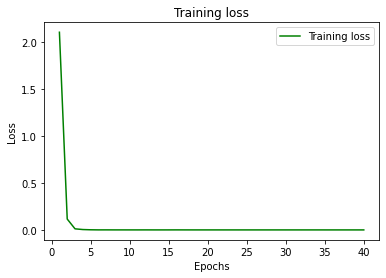

In [ ]:
loss_train = densehist6.history['loss']
epochs = range(1,41)
plt.plot(epochs, loss_train, 'g', label='Training loss')
plt.title('Training loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

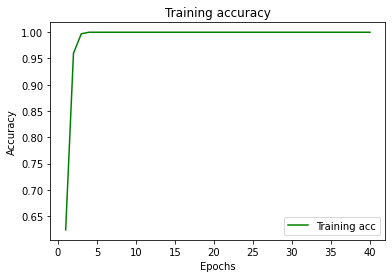

In [ ]:
acc_train = densehist6.history['Accuracy']
epochs = range(1,41)
plt.plot(epochs, acc_train, 'g', label='Training acc')
plt.title('Training accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

#### 512 nodes on custom layer

In [ ]:
# load model
from keras.applications.densenet import DenseNet201
model7 = DenseNet201(weights='imagenet', include_top=False, input_shape= img_dim)
# add new classifier layers
flat1 = Flatten()(model7.layers[-1].output)
class1 = Dense(512, activation='relu')(flat1)
output = Dense(3, activation='softmax')(class1)
# define new model
model7 = Model(inputs=model7.inputs, outputs=output)
# summarize
model7.summary()

74850304/74836368 [==============================] - 1s 0us/step
Model: "model_4"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_5 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 zero_padding2d_8 (ZeroPadding2  (None, 230, 230, 3)  0          ['input_5[0][0]']                
 D)                                                                                               
                                                                                                  
 conv1/conv (Conv2D)            (None, 112, 112, 64  9408        ['zero_padding2d_8[0][0]']       
                           

In [ ]:
model7.compile(optimizer = tf.keras.optimizers.Adam(learning_rate=0.0001), loss = 'categorical_crossentropy',metrics = ['Accuracy', 'Precision', 'Recall'])

In [ ]:
densehist7 = model7.fit(X_train, y_train, validation_data=(X_val, y_val), batch_size = batch_size, epochs = 80)

Epoch 1/80
21/21 [==============================] - 31s 510ms/step - loss: 1.7886 - Accuracy: 0.5908 - precision: 0.6060 - recall: 0.5744 - val_loss: 1.3866 - val_Accuracy: 0.3333 - val_precision: 0.4783 - val_recall: 0.2619
Epoch 2/80
21/21 [==============================] - 7s 321ms/step - loss: 0.1261 - Accuracy: 0.9494 - precision: 0.9607 - recall: 0.9464 - val_loss: 2.1684 - val_Accuracy: 0.3690 - val_precision: 0.3750 - val_recall: 0.3571
Epoch 3/80
21/21 [==============================] - 7s 322ms/step - loss: 0.0159 - Accuracy: 0.9970 - precision: 0.9970 - recall: 0.9970 - val_loss: 2.8090 - val_Accuracy: 0.4167 - val_precision: 0.4167 - val_recall: 0.4167
Epoch 4/80
21/21 [==============================] - 7s 324ms/step - loss: 0.0036 - Accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - val_loss: 3.2019 - val_Accuracy: 0.3214 - val_precision: 0.3293 - val_recall: 0.3214
Epoch 5/80
21/21 [==============================] - 7s 322ms/step - loss: 0.0019 - Accuracy: 1.0000 - p

In [ ]:
predictions = model7.predict(X_test)
predictions = np.argmax(predictions, axis=1)

rounded_labels=np.argmax(y_test, axis=1)
rounded_labels[1]
from sklearn.metrics import classification_report
print(classification_report(rounded_labels,predictions,target_names = ['CLL','FL','MCL']))

              precision    recall  f1-score   support

         CLL       0.96      0.96      0.96        28
          FL       0.93      0.96      0.95        28
         MCL       0.93      0.89      0.91        28

    accuracy                           0.94        84
   macro avg       0.94      0.94      0.94        84
weighted avg       0.94      0.94      0.94        84



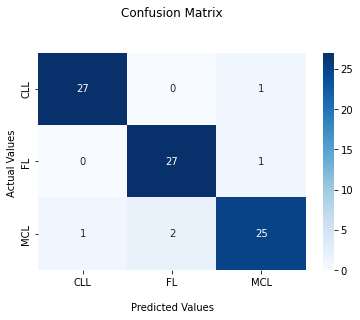

In [ ]:
target_names = ['CLL','FL','MCL']
cf_matrix = confusion_matrix(rounded_labels, predictions)
ax = sns.heatmap(cf_matrix, annot=True, cmap='Blues')
ax.set_title('Confusion Matrix\n\n');
ax.set_xlabel('\nPredicted Values')
ax.set_ylabel('Actual Values ');
## Ticket labels - List must be in alphabetical order
ax.xaxis.set_ticklabels(target_names)
ax.yaxis.set_ticklabels(target_names)
## Display the visualization of the Confusion Matrix.
plt.show()

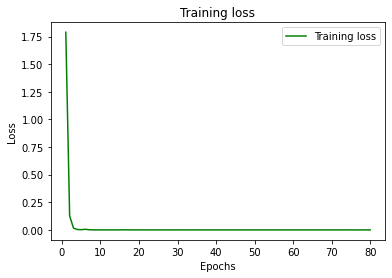

In [ ]:
loss_train = densehist7.history['loss']
epochs = range(1,81)
plt.plot(epochs, loss_train, 'g', label='Training loss')
plt.title('Training loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

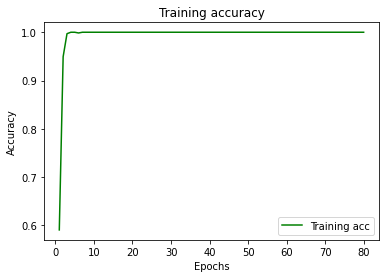

In [ ]:
acc_train = densehist7.history['Accuracy']
epochs = range(1,81)
plt.plot(epochs, acc_train, 'g', label='Training acc')
plt.title('Training accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

#### 1024 nodes on custom layer

In [ ]:
# load model
from keras.applications.densenet import DenseNet201
model8 = DenseNet201(weights='imagenet', include_top=False, input_shape= img_dim)
# add new classifier layers
flat1 = Flatten()(model8.layers[-1].output)
class1 = Dense(1024, activation='relu')(flat1)
output = Dense(3, activation='softmax')(class1)
# define new model
model8 = Model(inputs=model8.inputs, outputs=output)
# summarize
model8.summary()

Model: "model_5"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_6 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 zero_padding2d_10 (ZeroPadding  (None, 230, 230, 3)  0          ['input_6[0][0]']                
 2D)                                                                                              
                                                                                                  
 conv1/conv (Conv2D)            (None, 112, 112, 64  9408        ['zero_padding2d_10[0][0]']      
                                )                                                           

In [ ]:
model8.compile(optimizer = tf.keras.optimizers.Adam(learning_rate=0.0001), loss = 'categorical_crossentropy',metrics = ['Accuracy', 'Precision', 'Recall'])

In [ ]:
densehist8 = model8.fit(X_train, y_train, validation_data=(X_val, y_val), batch_size = batch_size, epochs = 80)

Epoch 1/80
21/21 [==============================] - 30s 472ms/step - loss: 3.6877 - Accuracy: 0.5149 - precision: 0.5197 - recall: 0.4911 - val_loss: 1.5843 - val_Accuracy: 0.3095 - val_precision: 0.3099 - val_recall: 0.2619
Epoch 2/80
21/21 [==============================] - 7s 331ms/step - loss: 0.1561 - Accuracy: 0.9524 - precision: 0.9621 - recall: 0.9449 - val_loss: 2.2015 - val_Accuracy: 0.3333 - val_precision: 0.3293 - val_recall: 0.3214
Epoch 3/80
21/21 [==============================] - 7s 331ms/step - loss: 0.0246 - Accuracy: 0.9955 - precision: 0.9970 - recall: 0.9940 - val_loss: 2.5274 - val_Accuracy: 0.3095 - val_precision: 0.3095 - val_recall: 0.3095
Epoch 4/80
21/21 [==============================] - 7s 328ms/step - loss: 0.0046 - Accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - val_loss: 3.4729 - val_Accuracy: 0.3095 - val_precision: 0.3133 - val_recall: 0.3095
Epoch 5/80
21/21 [==============================] - 7s 328ms/step - loss: 0.0033 - Accuracy: 1.0000 - p

In [ ]:
predictions = model8.predict(X_test)
predictions = np.argmax(predictions, axis=1)

rounded_labels=np.argmax(y_test, axis=1)
rounded_labels[1]
from sklearn.metrics import classification_report
print(classification_report(rounded_labels,predictions,target_names = ['CLL','FL','MCL']))

              precision    recall  f1-score   support

         CLL       0.93      0.96      0.95        28
          FL       0.93      1.00      0.97        28
         MCL       0.96      0.86      0.91        28

    accuracy                           0.94        84
   macro avg       0.94      0.94      0.94        84
weighted avg       0.94      0.94      0.94        84



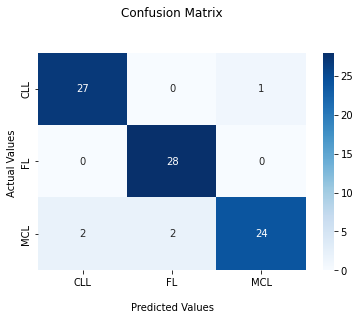

In [ ]:
target_names = ['CLL','FL','MCL']
cf_matrix = confusion_matrix(rounded_labels, predictions)
ax = sns.heatmap(cf_matrix, annot=True, cmap='Blues')
ax.set_title('Confusion Matrix\n\n');
ax.set_xlabel('\nPredicted Values')
ax.set_ylabel('Actual Values ');
## Ticket labels - List must be in alphabetical order
ax.xaxis.set_ticklabels(target_names)
ax.yaxis.set_ticklabels(target_names)
## Display the visualization of the Confusion Matrix.
plt.show()

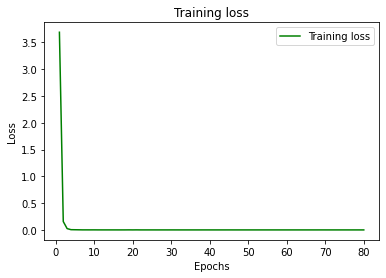

In [ ]:
loss_train = densehist8.history['loss']
epochs = range(1,81)
plt.plot(epochs, loss_train, 'g', label='Training loss')
plt.title('Training loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

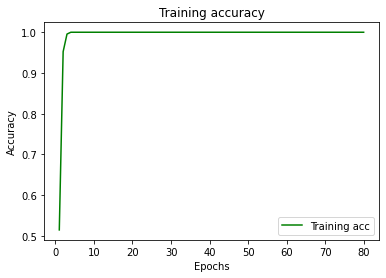

In [ ]:
acc_train = densehist8.history['Accuracy']
epochs = range(1,81)
plt.plot(epochs, acc_train, 'g', label='Training acc')
plt.title('Training accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

# THE END